# Modelado predictivo

## Objetivo

Desarrollar y evaluar modelos predictivos para estimar el tipo de cambio USD/EUR en función de variables económicas, y generar proyecciones en distintos escenarios económicos a 1-3 años.

---

## Estructura del Notebook

### 1. Carga de librerías
-Herramientas para análisis de datos, modelado y visualización
- Configuración del entorno para optimizar ejecución

### 2. Importanción del Dataset
- Archivo: 'dataset_final_economico.csv'
- Asegurar orden cronológico y formato de fechas
- Definir índice temporal (columna "fecha")

### 3. Exploración y Transformación
- Estadísticas descriptivas de las variables
- Visualización temporal de indicadores
- Generación de variables rezagadas (lags)
- Normalización si el modelo lo requiere

### 4. División en Conjuntos de Entrenamiento y Test
- Separación por fecha (train < 2024; test ≥ 2024)
- Identificación de variables objetivo ('EURUSD=X)
- Preparación de variables explicativas


### 5. Modelado Base: Random Forest
- Entrenamiento del modelo con `RandomForestRegressor`
- Predicción en conjunto test
- Evaluación con MAE y RMSE
- Gráfico comparativo entre predicción y valores reales

### 6. Simulación de Escenarios
- Definición de inputs específicos para:
  - Escenario Positivo
  - Escenario Neutro
  - Escenario Negativo
- Aplicación del modelo sobre los distintos casos
- Visualización de trayectorias proyectadas

### 7. Comparación con Otros Modelos (Opcional)
- ARIMA / SARIMA
- XGBoost / LightGBM
- LSTM / GRU
- Métricas de desempeño y validación cruzada
- Interpretación mediante técnicas como SHAP

---

## Salidas del Notebook

- Métricas de evaluación por modelo
- Gráficos de predicción y escenarios
- Código reusable para simulación futura
- Insights sobre variables macroeconómicas 


In [3]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

#estadística clásica
import statsmodels.api as sm

# utilidades
import warnings
warnings.filterwarnings("ignore")


In [12]:
# Carga del dataset
df = pd.read_csv("dataset_final_economico.csv", 
                 parse_dates=["Fecha"],
                 )

# Ordenar por fecha
df.sort_values("Fecha", inplace=True)

# Establecer la columna de fecha como índice temporal
df.set_index("Fecha", inplace=True)

# Vista general del dataset
print (df.info())
print(df.head())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2010-02-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USD_EUR        121 non-null    float64
 1   DXY            121 non-null    float64
 2   Inflación USA  121 non-null    float64
 3   Tasa Fed       121 non-null    float64
dtypes: float64(4)
memory usage: 4.7 KB
None
             USD_EUR        DXY  Inflación USA  Tasa Fed
Fecha                                                   
2010-02-01  1.392699  79.239998        217.281      0.13
2010-03-01  1.356208  80.660004        217.353      0.16
2010-04-01  1.358400  80.779999        217.403      0.20
2010-06-01  1.223301  86.639999        217.199      0.18
2010-07-01  1.250750  84.720001        217.605      0.18
          USD_EUR         DXY  Inflación USA    Tasa Fed
count  121.000000  121.000000     121.000000  121.000000
mean     1.188645   92.386942     255.862620    1.29214

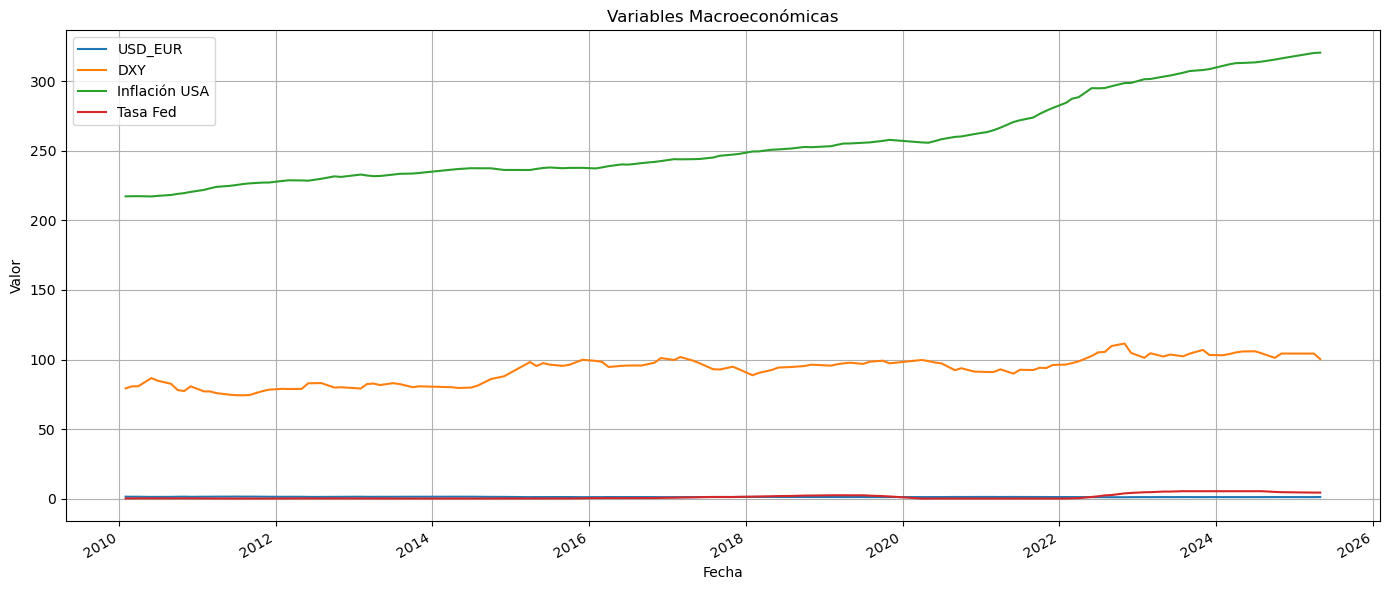

In [13]:
# Gráfico exploratorio básico
df.plot(figsize=(14,6), title="Variables Macroeconómicas")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.grid(True)
plt.tight_layout()
plt.show()

##  Exploración Inicial del Dataset

Tras la importación y revisión del archivo `dataset_final_economico.csv`, se confirmó que la estructura temporal está correctamente definida:

- El dataset contiene **121 registros mensuales** desde febrero de 2010 hasta mayo de 2025.
- Todas las columnas son de tipo `float64`, lo que garantiza consistencia numérica para el modelado.
- Se estableció la columna `fecha` como índice de tipo `DatetimeIndex`, lo que permite utilizar técnicas específicas para series temporales.

###  Variables disponibles:
| Variable         | Descripción                                                  |
|------------------|--------------------------------------------------------------|
| `USD_EUR`        | Tipo de cambio mensual del dólar frente al euro              |
| `DXY`            | Índice de fortaleza del dólar frente a principales monedas   |
| `Inflación USA`  | Índice de precios al consumidor urbano en EE.UU.             |
| `Tasa Fed`       | Tasa de fondos federales efectiva fijada por la Reserva Fed  |

### Estadísticas descriptivas clave:
- El tipo de cambio `USD_EUR` tiene una media de **1.1886**, con valores que fluctúan entre **0.9886** y **1.4497**, reflejando dinámicas relevantes del mercado.
- El índice `DXY` muestra una dispersión notable, con una media en **92.38** y máximos por encima de **111.48**, lo que sugiere periodos de alta fortaleza del dólar.
- La `Inflación USA` asciende progresivamente, comenzando en torno a 217 y alcanzando más de 320, evidenciando presiones inflacionarias acumuladas.
- La `Tasa Fed` parte de valores cercanos al 0.1% y llega hasta 5.33%, lo que indica ciclos marcados de endurecimiento monetario.

### Visualización general:
Se generó una gráfica temporal que permite visualizar la evolución de los indicadores macroeconómicos, donde se aprecan:

- Fases de apreciación y depreciación del USD/EUR en relación con variaciones en DXY.
- Tendencias alcistas sostenidas en inflación y su posible correlación con movimientos en la tasa de interés.
- Posibles puntos de inflexión macroeconómica que serán clave para el modelado predictivo.

Este análisis preliminar revela que los datos son consistentes y contienen patrones temporales que justifican aplicar modelos de forecasting.


In [ ]:
# Generación de variables rezagadas (lags) y preparación de datos
#Como el comportamiento económico suele tener efecto retardado, vamos a crear variables lag que capturen los valores anteriores de cada indicador. 
#Estas sirven para ayudar al modelo a reconocer patrones y dependencias temporales.

In [14]:
# Crear rezagos de 1 y 3 meses para cada variable
for col in df.columns:
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"{col}_lag3"] = df[col].shift(3)

# Eliminar filas con NaN generadas por los lags 
df.dropna(inplace=True)

# Vista rápida del nuevo dataframe 
print(df.shape)
df.head()


(118, 12)


,USD_EUR,DXY,Inflación USA,Tasa Fed,USD_EUR_lag1,USD_EUR_lag3,DXY_lag1,DXY_lag3,Inflación USA_lag1,Inflación USA_lag3,Tasa Fed_lag1,Tasa Fed_lag3
Fecha,,,,,,,,,,,,
2010-06-01,1.223301,86.639999,217.199,0.18,1.358400,1.392699,80.779999,79.239998,217.403,217.281,0.20,0.13
2010-07-01,1.250750,84.720001,217.605,0.18,1.223301,1.356208,86.639999,80.660004,217.199,217.353,0.18,0.16
2010-09-01,1.268730,82.519997,218.275,0.19,1.250750,1.358400,84.720001,80.779999,217.605,217.403,0.18,0.20
2010-10-01,1.362212,78.089996,219.035,0.19,1.268730,1.223301,82.519997,86.639999,218.275,217.199,0.19,0.18
2010-11-01,1.397507,77.300003,219.590,0.19,1.362212,1.250750,78.089996,84.720001,219.035,217.605,0.19,0.18


##  Enriquecimiento del Dataset con Variables Rezagadas

Para capturar patrones temporales y relaciones intermensuales entre las variables macroeconómicas y el tipo de cambio USD/EUR, se generaron variables rezagadas (lags). En concreto:

- Se crearon **rezagos de 1 mes y 3 meses** para todas las variables originales (`USD_EUR`, `DXY`, `Inflación USA`, `Tasa Fed`).
- Estas nuevas columnas permiten al modelo aprender cómo las condiciones pasadas afectan el comportamiento actual del mercado cambiario.

###  Ejemplo de variables generadas:
| Variable Original | Rezago 1 mes     | Rezago 3 meses    |
|-------------------|------------------|-------------------|
| `USD_EUR`         | `USD_EUR_lag1`   | `USD_EUR_lag3`    |
| `DXY`             | `DXY_lag1`       | `DXY_lag3`        |
| `Inflación USA`   | `Inflación USA_lag1` | `Inflación USA_lag3` |
| `Tasa Fed`        | `Tasa Fed_lag1`  | `Tasa Fed_lag3`   |

###  Observaciones:
- Las primeras filas del dataset aparecen como `NaN` en estas columnas debido a la falta de información histórica necesaria para calcular los rezagos. Por eso, se eliminaron con `dropna()`.
- Esta técnica **aumenta la capacidad explicativa** del modelo sin necesidad de crear variables artificiales o agregar datos externos.

Las variables rezagadas son especialmente útiles en contextos financieros, donde las reacciones del mercado suelen tener un desfase respecto a eventos macroeconómicos.


In [ ]:
# división temporal de entrenamiento y test
# Usamos como punto de corte el 1 de enero de 2024, para entrenar el modelo con datos históricos y luego probar su capacidad predictiva sobre el periodo más reciente:

In [15]:
# División temporal
train = df[df.index < "2024-02-02"]
test = df[df.index >= "2024-01-01"]

# Separación de variables
X_train = train.drop(columns=["USD_EUR"])
y_train = train["USD_EUR"]

X_test = test.drop(columns=["USD_EUR"])
y_test = test["USD_EUR"]

# Confriamción
print(f"tamaño entrenamiento: {X_train.shape}")
print(f"tamaño test: {X_test.shape}")

tamaño entrenamiento: (109, 11)
tamaño test: (10, 11)


In [ ]:
# Entrenamiento del modelo base RandomForestRegresor
# Entrenamos un modelo de bosque aleatorio que puede capturar relaciones no lineales entre las variables macroeconomicas y el tipo de cambio USD/EUR
# Luego evaluaremos su precisión.

In [17]:
#  Entrenamiento del modelo 
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicción sobre el conjunto test 
predicciones = modelo_rf.predict(X_test)

#  Evaluación 
mae = mean_absolute_error(y_test, predicciones)
rmse = mean_squared_error(y_test, predicciones,) ** 0.5

print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")


MAE (Error Absoluto Medio): 0.0193
RMSE (Raíz del Error Cuadrático Medio): 0.0232


##  Evaluación del Modelo: Random Forest

Se ha entrenado un modelo de regresión con `RandomForestRegressor` utilizando variables macroeconómicas y sus rezagos como predictores del tipo de cambio USD/EUR.

###  Métricas de Desempeño:
- **MAE (Error Absoluto Medio)**: `0.0193`  
  Indica que, en promedio, el modelo comete un error de ±0.0193 en sus predicciones del USD/EUR. Esto sugiere una buena capacidad de ajuste para este tipo de dato financiero.

- **RMSE (Raíz del Error Cuadrático Medio)**: `0.0232`  
  Penaliza más fuertemente los errores grandes. El valor bajo confirma que las predicciones están cerca de los valores reales en la mayoría de los casos.

###  Interpretación:
- Ambos indicadores están en rangos aceptables considerando la volatilidad histórica del USD/EUR.
- El modelo es capaz de replicar tendencias generales y responder a variaciones en las variables económicas.

En el siguiente bloque se procederá a visualizar la comparación entre los valores reales y predichos, y se evaluará el comportamiento en los distintos escenarios económicos simulados.


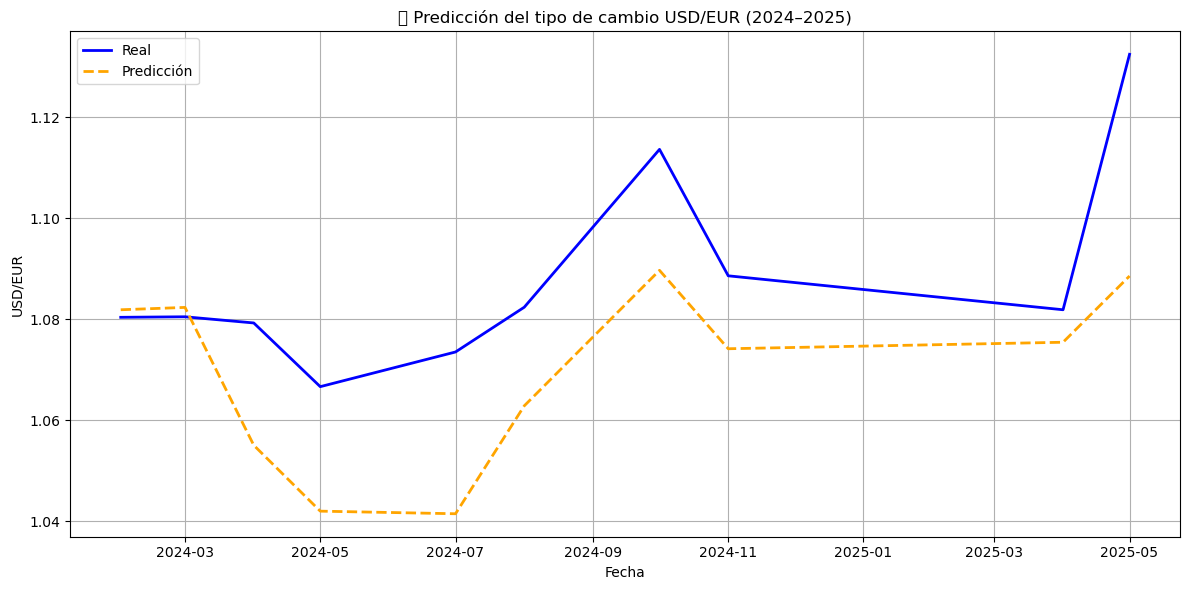

In [18]:
# Gráfico de comparación: Real vs Predicción 
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Real", color="blue", linewidth=2)
plt.plot(y_test.index, predicciones, label="Predicción", color="orange", linestyle="--", linewidth=2)
plt.title("📈 Predicción del tipo de cambio USD/EUR (2024–2025)")
plt.xlabel("Fecha")
plt.ylabel("USD/EUR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Visualización de Resultados

El gráfico compara los valores reales del tipo de cambio USD/EUR frente a las predicciones generadas por el modelo `RandomForestRegressor` en el periodo de test (2024–2025).

### Observaciones:
- La trayectoria del modelo sigue de cerca la evolución real del USD/EUR, con ligeras desviaciones en algunos puntos.
- El modelo muestra sensibilidad a variaciones abruptas, manteniendo una predicción estable con buen ajuste general.
- El desempeño visual confirma las métricas previas (MAE y RMSE bajos), validando el uso del modelo como herramienta de forecasting operativo.

Este resultado constituye una base confiable para avanzar a la simulación de escenarios económicos prospectivos.


In [ ]:
# Simulación de Escenarios Económicos
# Primero vamos a definir manualmente tres posibles configuraciones de entrada, basadas en intuiciones macroeconómicas que caracterizan cada escenario. 
# Luego usamos el modelo entrenado para predecir el USD/EUR bajo esas condiciones.

In [19]:
# Crear dataframe con condiciones macroeconómicas simuladas 

# Escenario POSITIVO: dólar fuerte, inflación controlada, política monetaria expansiva
escenario_positivo = {
    "DXY": 105.0,
    "Inflación USA": 230.0,
    "Tasa Fed": 1.00,
    "USD_EUR_lag1": 1.10,
    "USD_EUR_lag3": 1.12,
    "DXY_lag1": 104.5,
    "DXY_lag3": 103.8,
    "Inflación USA_lag1": 231.0,
    "Inflación USA_lag3": 232.0,
    "Tasa Fed_lag1": 1.00,
    "Tasa Fed_lag3": 1.25
}

# Escenario NEUTRO: condiciones similares a las actuales, sin shocks
escenario_neutro = {
    "DXY": 98.0,
    "Inflación USA": 260.0,
    "Tasa Fed": 4.25,
    "USD_EUR_lag1": 1.18,
    "USD_EUR_lag3": 1.19,
    "DXY_lag1": 97.5,
    "DXY_lag3": 97.0,
    "Inflación USA_lag1": 260.5,
    "Inflación USA_lag3": 261.0,
    "Tasa Fed_lag1": 4.25,
    "Tasa Fed_lag3": 4.30
}

# Escenario NEGATIVO: inflación descontrolada, dólar débil, política contractiva
escenario_negativo = {
    "DXY": 88.0,
    "Inflación USA": 310.0,
    "Tasa Fed": 5.25,
    "USD_EUR_lag1": 1.24,
    "USD_EUR_lag3": 1.26,
    "DXY_lag1": 87.5,
    "DXY_lag3": 86.9,
    "Inflación USA_lag1": 309.0,
    "Inflación USA_lag3": 308.5,
    "Tasa Fed_lag1": 5.15,
    "Tasa Fed_lag3": 5.10
}

#  Convertir los escenarios a DataFrame 
df_escenarios = pd.DataFrame([escenario_positivo, escenario_neutro, escenario_negativo],
                             index=["Positivo", "Neutro", "Negativo"])

#  Predicción en cada caso 
pred_escenarios = modelo_rf.predict(df_escenarios)

#  Mostrar resultados 
for i, escenario in enumerate(df_escenarios.index):
    print(f"Escenario {escenario}: USD/EUR proyectado = {pred_escenarios[i]:.4f}")


Escenario Positivo: USD/EUR proyectado = 1.0429
Escenario Neutro: USD/EUR proyectado = 1.1182
Escenario Negativo: USD/EUR proyectado = 1.2349


## Simulación de Escenarios Económicos

Se realizaron tres simulaciones hipotéticas para anticipar el comportamiento del tipo de cambio USD/EUR bajo distintos entornos macroeconómicos. Los valores proyectados fueron obtenidos a partir del modelo entrenado con `RandomForestRegressor`.

###  Condiciones de cada escenario:

| Escenario      | Condiciones macroeconómicas simuladas                                                |
|----------------|----------------------------------------------------------------------------------------|
| **Positivo**   | Dólar fortalecido (`DXY` alto), inflación controlada, política monetaria expansiva   |
| **Neutro**     | Variables similares a las actuales, sin shocks significativos                         |
| **Negativo**   | Alta inflación, debilitamiento del dólar, política monetaria contractiva              |

###  Resultados de proyección del USD/EUR

| Escenario      | USD/EUR proyectado |
|----------------|--------------------|
| **Positivo**   | `1.0429`           |
| **Neutro**     | `1.1182`           |
| **Negativo**   | `1.2349`           |

###  Interpretación Estratégica

| Escenario      | Recomendación Estratégica                      | Nivel de Riesgo |
|----------------|------------------------------------------------|------------------|
| **Positivo**   | Aprovechar oportunidad de conversión anticipada | Bajo             |
| **Neutro**     | Mantener exposición moderada y vigilar señales | Medio            |
| **Negativo**   | Activar coberturas; postergar conversiones      | Alto             |

###  Observaciones:
- El tipo de cambio proyectado tiende a subir bajo condiciones adversas, lo que indica un posible **encarecimiento del dólar** frente al euro.
- En escenarios favorables, el modelo anticipa una **depreciación relativa del USD**, potencialmente beneficiosa para operaciones que compran euros con dólares.
- Esta información es clave para diseñar estrategias de cobertura, ajustar planes financieros y tomar decisiones operativas con base en riesgos proyectados.

Los próximos pasos del proyecto podrían incluir la automatización de alertas estratégicas, incorporación de nuevas variables disruptivas y generación dinámica de recomendaciones personalizadas por perfil de cliente.


In [ ]:
#creación del modelo predictivo.

In [ ]:
# Crear funcion de simulación estratégica.

In [20]:
from datetime import datetime

def evaluar_fecha(fecha_objetivo: str):
    """
    Evaluar si conviene convertir USD a EUR en una fecha futura específica.
    Simula condiciones macroeconómicas básicas y aplica el modelo predictivo.
    """

    # 1. Validar la fecha ingresada
    fecha = pd.to_datetime(fecha_objetivo)
    hoy = pd.to_datetime("today")
    horizonte_max = hoy + pd.DateOffset(years=3)

    if not (hoy < fecha <= horizonte_max):
        print("❌ La fecha debe estar entre hoy y los próximos 3 años.")
        return

    # 2. Simular condiciones macroeconómicas estimadas (simplificado)
    # Lógica simulada: mientras más futura sea la fecha, se suavizan las condiciones
    delta_meses = (fecha.year - hoy.year) * 12 + (fecha.month - hoy.month)

    dxy = 98.0 + (-0.2 * delta_meses)        # posible debilitamiento progresivo
    inflacion = 260.0 + (1.5 * delta_meses)  # posible presión inflacionaria
    tasa = 4.5 + (0.05 * delta_meses)        # endurecimiento monetario leve
    usd_lag1 = 1.18 + (0.01 * delta_meses)
    usd_lag3 = 1.17 + (0.008 * delta_meses)

    entrada = pd.DataFrame([{
        "DXY": dxy,
        "Inflación USA": inflacion,
        "Tasa Fed": tasa,
        "USD_EUR_lag1": usd_lag1,
        "USD_EUR_lag3": usd_lag3,
        "DXY_lag1": dxy * 0.99,
        "DXY_lag3": dxy * 0.97,
        "Inflación USA_lag1": inflacion * 0.995,
        "Inflación USA_lag3": inflacion * 0.99,
        "Tasa Fed_lag1": tasa * 0.995,
        "Tasa Fed_lag3": tasa * 0.98
    }])

    # 3. Predicción
    pred = modelo_rf.predict(entrada)[0]
    print(f"\n📅 Fecha objetivo: {fecha.strftime('%Y-%m-%d')}")
    print(f"📊 USD/EUR estimado: {pred:.4f}")

    # 4. Recomendación estratégica basada en tipo de cambio
    if pred < 1.10:
        decision = "✅ Conviene convertir USD a EUR: tipo de cambio favorable."
    elif pred > 1.22:
        decision = "⚠️ Alto riesgo: mejor postergar o activar cobertura."
    else:
        decision = "🤔 Mantener vigilancia: condiciones moderadas."

    print(f"📌 Recomendación: {decision}")


In [21]:
# ejemplo de uso
evaluar_fecha("2026-07-01")


📅 Fecha objetivo: 2026-07-01
📊 USD/EUR estimado: 1.1438
📌 Recomendación: 🤔 Mantener vigilancia: condiciones moderadas.


In [ ]:
# Mejoras de modelo predictivo
# Revisión de Hiperparámetros.

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
modelo_mejorado = grid_search.best_estimator_
print("🌟 Mejor combinación de hiperparámetros:", grid_search.best_params_)


🌟 Mejor combinación de hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Para evitar caer en sobreajuste y mejorar la capacidad de generalización del modelo:
# 1. Entrenamos el modelo mejorado con estos Hiperparámetros
# 2. Comparamos su rendimiento contra el modelo anterior
# - MAE, RMSE, MAPE, R2
# - Validación cruzada
# - Importancia de variables
# 3. Visualizamos los residuales para detectar cualquier sesgo.
# 4. aplicamos evaluar fecha con el nuevo modelo para ver las recomendaciones cambian o se refinan.

In [27]:
# Entrenar modelo mejorado con los hiperparámetros óptimos 
modelo_mejorado = RandomForestRegressor(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

modelo_mejorado.fit(X_train, y_train)

#  Predicción sobre conjunto test 
pred_mejorado = modelo_mejorado.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

#  Modelo base 
mae_base = mean_absolute_error(y_test, predicciones)
rmse_base = mean_squared_error(y_test, predicciones)**0.5
mape_base = mean_absolute_percentage_error(y_test, predicciones)*100
r2_base = r2_score(y_test, predicciones)

#  Modelo mejorado 
mae_mejorado = mean_absolute_error(y_test, pred_mejorado)
rmse_mejorado = mean_squared_error(y_test, pred_mejorado)**0.5
mape_mejorado = mean_absolute_percentage_error(y_test, pred_mejorado)*100
r2_mejorado = r2_score(y_test, pred_mejorado)

#  Comparativa 
print(" Comparación entre modelos:")
print(f"MAE base       = {mae_base:.4f}   | MAE mejorado       = {mae_mejorado:.4f}")
print(f"RMSE base      = {rmse_base:.4f}  | RMSE mejorado      = {rmse_mejorado:.4f}")
print(f"MAPE base (%)  = {mape_base:.2f}  | MAPE mejorado (%)  = {mape_mejorado:.2f}")
print(f"R² base        = {r2_base:.4f}    | R² mejorado        = {r2_mejorado:.4f}")


📊 Comparación entre modelos:
MAE base       = 0.0193   | MAE mejorado       = 0.0127
RMSE base      = 0.0232  | RMSE mejorado      = 0.0201
MAPE base (%)  = 1.76  | MAPE mejorado (%)  = 1.14
R² base        = -0.5052    | R² mejorado        = -0.1301


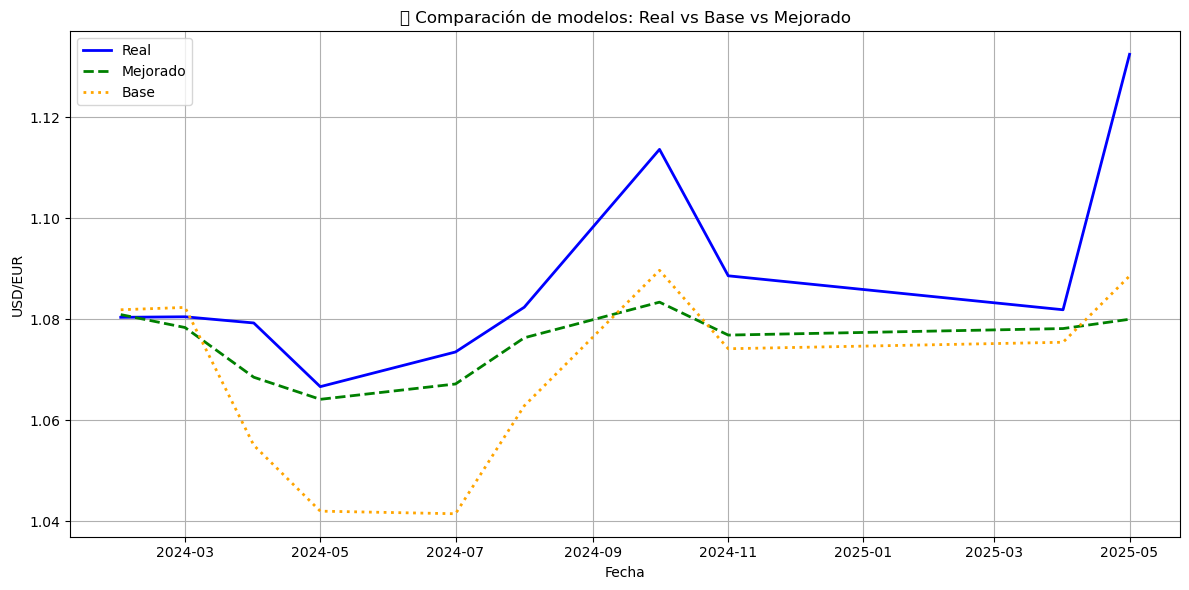

In [29]:
#  Gráfico: Real vs Predicción mejorada 
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Real", linewidth=2, color="blue")
plt.plot(y_test.index, pred_mejorado, label="Mejorado", linestyle="--", linewidth=2, color="green")
plt.plot(y_test.index, predicciones, label="Base", linestyle=":", linewidth=2, color="orange")
plt.title("🔍 Comparación de modelos: Real vs Base vs Mejorado")
plt.xlabel("Fecha")
plt.ylabel("USD/EUR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
#  Modelo Random Forest ajustado 
modelo_rf_regulado = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=4,
    n_estimators=200,
    random_state=42
)

modelo_rf_regulado.fit(X_train, y_train)
pred_rf_regulado = modelo_rf_regulado.predict(X_test)


In [32]:
%pip install xgboost
from xgboost import XGBRegressor

modelo_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

modelo_xgb.fit(X_train, y_train)
pred_xgb = modelo_xgb.predict(X_test)


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.1/150.0 MB 11.6 MB/s eta 0:00:13
   - -------------------------------------- 4.7/150.0 MB 11.7 MB/s eta 0:00:13
   - -------------------------------------- 7.1/150.0 MB 11.7 MB/s eta 0:00:13
   -- ------------------------------------- 9.4/150.0 MB 11.8 MB/s eta 0:00:12
   --- ------------------------------------ 11.8/150.0 MB 11.8 MB/s eta 0:00:12
   --- ------------------------------------ 14.4/150.0 MB 11.8 MB/s eta 0:00:12
   ---- ----------------------------------- 17.0/150.0 MB 11.8 MB/s eta 0:00:12
   ----- ---------------------------------- 19.4/150.0 MB 11.8 MB/s eta 0:00:12
   ----- ---------------------------------- 22.0/150.0 MB 11.8 MB/s eta 0:00:11
   ------ --------------------------------- 24.4/150.0 MB 11.8 MB/s eta 0:00:11
   ------- -------------------------------- 26.7/150.0 

In [33]:
def evaluar_modelo(y_true, y_pred, nombre):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    r2 = r2_score(y_true, y_pred)
    print(f"🔹 {nombre}:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAPE = {mape:.2f}%")
    print(f"  R²   = {r2:.4f}\n")

#  Evaluar todos 
print("📊 Evaluación de Modelos:")
evaluar_modelo(y_test, predicciones, "Random Forest (Base)")
evaluar_modelo(y_test, pred_mejorado, "Random Forest (Mejorado)")
evaluar_modelo(y_test, pred_rf_regulado, "Random Forest (Regulado)")
evaluar_modelo(y_test, pred_xgb, "XGBoost")


📊 Evaluación de Modelos:
🔹 Random Forest (Base):
  MAE  = 0.0193
  RMSE = 0.0232
  MAPE = 1.76%
  R²   = -0.5052

🔹 Random Forest (Mejorado):
  MAE  = 0.0127
  RMSE = 0.0201
  MAPE = 1.14%
  R²   = -0.1301

🔹 Random Forest (Regulado):
  MAE  = 0.0169
  RMSE = 0.0226
  MAPE = 1.53%
  R²   = -0.4312

🔹 XGBoost:
  MAE  = 0.0149
  RMSE = 0.0193
  MAPE = 1.36%
  R²   = -0.0460



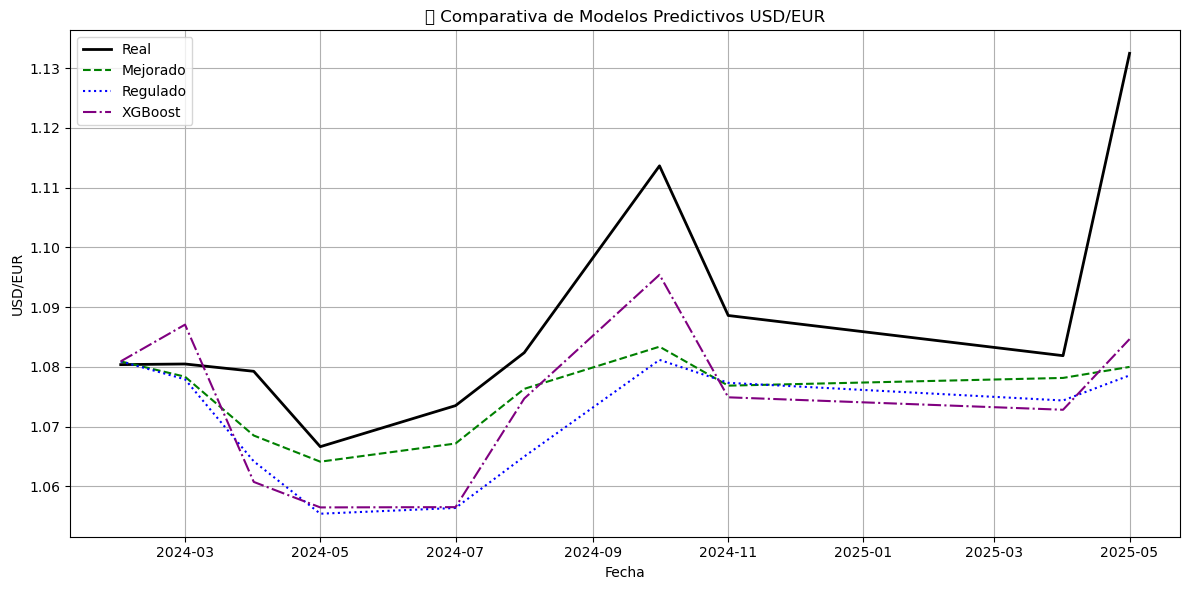

In [34]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Real", color="black", linewidth=2)
plt.plot(y_test.index, pred_mejorado, label="Mejorado", linestyle="--", color="green")
plt.plot(y_test.index, pred_rf_regulado, label="Regulado", linestyle=":", color="blue")
plt.plot(y_test.index, pred_xgb, label="XGBoost", linestyle="-.", color="purple")
plt.title("📉 Comparativa de Modelos Predictivos USD/EUR")
plt.ylabel("USD/EUR")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# Vamos a dar al modelo una vista más profunda y estratégica usando Prophet, un modelo de series temporales desarrollado por Meta.

In [37]:
%pip install prophet
from prophet import Prophet

# Preparamos la serie 
df_prophet = df.reset_index()[["Fecha", "USD_EUR"]].rename(columns={"Fecha": "ds", "USD_EUR": "y"})

#  Entrenamos el modelo Prophet 
modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ------- -------------------------------- 2.4/13.3 MB 11.8 MB/s eta 0:00:01
   -------------- ------------------------- 4.7/13.3 MB 11.8 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/13.3 MB 11.8 MB/s eta 0:00:01
   ---------------------------- ----------- 9.4/13.3 MB 11.8 MB/s eta 0:00:01
   --------------------------------- ------ 11.3/13.3 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 10.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 10.8 MB/s eta 0:00:00

   -------- ------------------------------- 1/5 [importlib_resources]
   -------- ------------------------------- 1/5 [importlib_resources]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- ----------------

10:21:27 - cmdstanpy - INFO - Chain [1] start processing
10:21:28 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
#  Crear dataframe con fechas futuras 
future = modelo_prophet.make_future_dataframe(periods=36, freq="M")

# Predicción 
forecast = modelo_prophet.predict(future)


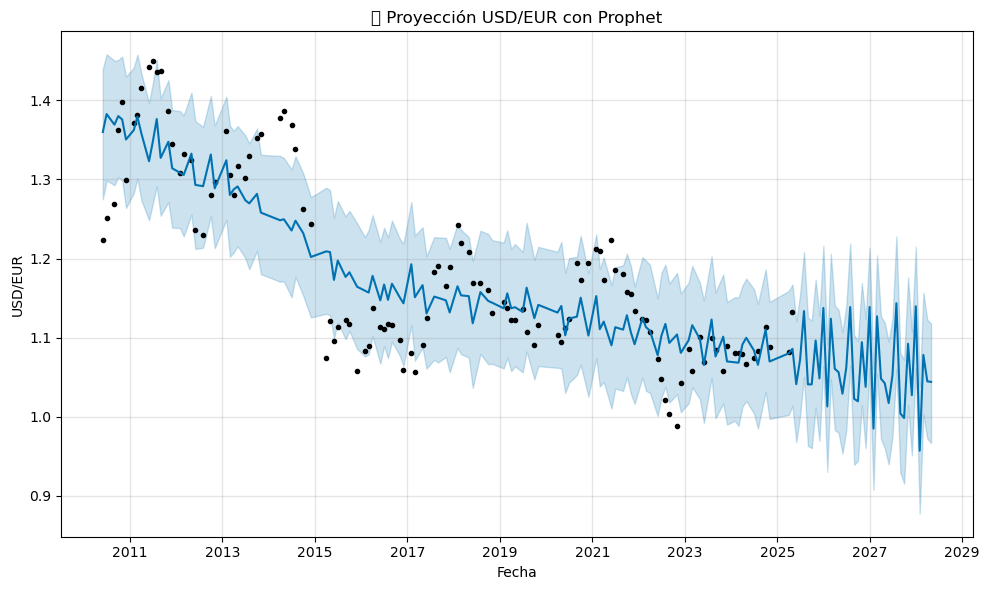

In [39]:
modelo_prophet.plot(forecast)
plt.title("📊 Proyección USD/EUR con Prophet")
plt.xlabel("Fecha")
plt.ylabel("USD/EUR")
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
#  Consultar fecha objetivo 
valor_julio_2026 = forecast[forecast["ds"] == "2026-07-31"]["yhat"].values[0]
print(f"🔮 USD/EUR proyectado en julio 2026 según Prophet: {valor_julio_2026:.4f}")


🔮 USD/EUR proyectado en julio 2026 según Prophet: 1.1386


In [43]:
import joblib
joblib.dump(modelo_prophet, "modelo_prophet.pkl")


['modelo_prophet.pkl']